In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
! unzip '/content/drive/MyDrive/Colab Notebooks/lfw.zip'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print ("MPS device not found.")

torch.Size([250, 250, 3])


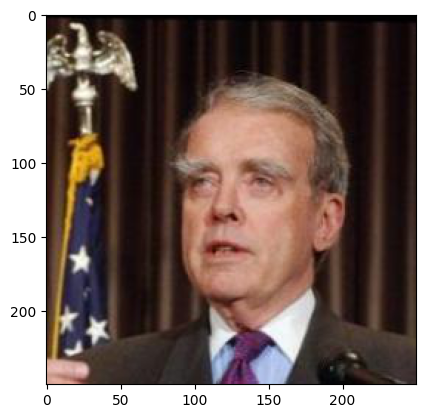

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [8]:
# Iterate over the dataloader
for x, y in dataloader:
    img = x[0]
    break

# Print the shape of the tensor
print("Dimensions of the image", img.shape)

# Assigning the dimesions from the shape array
channels, height, width = img.shape

print("Channel (1st Dimension):",channels)
print("Height (2nd Dimension):",height)
print("width (3rd Dimension):",width)

Dimensions of the image torch.Size([3, 250, 250])
Channel (1st Dimension): 3
Height (2nd Dimension): 250
width (3rd Dimension): 250


# Image Dimensions:

The image is represented in a form of 3D tensor, where the dimensions correspond to:

- **Channels (1st dimension):** The number of color channels in the image (RGB image).
- **Height (2nd dimension):** The height of the image in pixels.
- **Width (3rd dimension):** The width of the image in pixels.


# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Auto_Encoder(nn.Module):
    def __init__(self):
        super(Auto_Encoder, self).__init__()

        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(32)
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(64)

        # Decoder Layers
        self.dec_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(32)
        self.dec_conv2 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

        # Adaptive Pooling
        self.adaptive_pool = nn.AdaptiveAvgPool2d((250, 250))

    def encoder(self, x):
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        return x

    def decoder(self, x):
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = self.dec_conv2(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.adaptive_pool(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [13]:
# Create an instance of the Auto_Encoder class
model = Auto_Encoder()

In [14]:
sample_input = img.unsqueeze(0)

output = model(sample_input)
encoded_output = model.encoder(sample_input)
decoded_output = model.decoder(encoded_output)

# Print the shapes of the outputs
print("Shape of the input image:", output.shape)
print("Shape of encoded output:", encoded_output.shape)
print("Shape of decoded output:", decoded_output.shape)

Shape of the input image: torch.Size([1, 3, 250, 250])
Shape of encoded output: torch.Size([1, 64, 63, 63])
Shape of decoded output: torch.Size([1, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [15]:
# Calculate total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_params)

Total number of trainable parameters: 38979


In [16]:
# Create the optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Define the loss function
loss_function = torch.nn.MSELoss()

## **Explain what loss function you should use?**

When it comes to autoencoders for image reconstruction, Mean Squared Error (MSE) is frequently used as the default loss function. The reasons are:

- MSE is easy to work with when backpropagating neural networks for training because it is smooth and differentiable.
- The model really concentrates on getting those crucial details right when reconstructing images because it also has this cool property of being more sensitive to larger differences in values.

Statistically speaking, minimizing MSE is like maximizing the likelihood of our observed data, adding a bit of mathematical elegance to the choice.


##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [18]:
# Assuming model, loss_function, optim, and dataloader are already defined
num_epochs = 10  # Define the number of epochs

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for data in dataloader:
        inputs, _ = data

        # Zero the parameter gradients
        optim.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, inputs)

        # Backward pass and optimize
        loss.backward()
        optim.step()

        # Accumulate loss
        epoch_loss += loss.item()

    # Average loss for the epoch
    epoch_loss /= len(dataloader)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 0.0201
Epoch 2, Loss: 0.0020
Epoch 3, Loss: 0.0016
Epoch 4, Loss: 0.0013
Epoch 5, Loss: 0.0012
Epoch 6, Loss: 0.0011
Epoch 7, Loss: 0.0009
Epoch 8, Loss: 0.0009
Epoch 9, Loss: 0.0008
Epoch 10, Loss: 0.0008


## If your loss is not decreasing what do you have to do to troubleshoot it ?

I first changed the learning rate when I saw that the training loss wasn't decreasing because an incorrectly set learning rate can occasionally keep the model from learning as intended. To make sure my model wasn't overfitting or too simple, I also looked at its complexity. These factors can make it difficult to identify patterns in the data or result in overfitting. Additionally, since I knew that could have a significant impact on how well the model trains perform, I made sure my data was clean and properly preprocessed. Observing both the validation loss and the training loss enabled me to determine whether the problem was related to overfitting.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


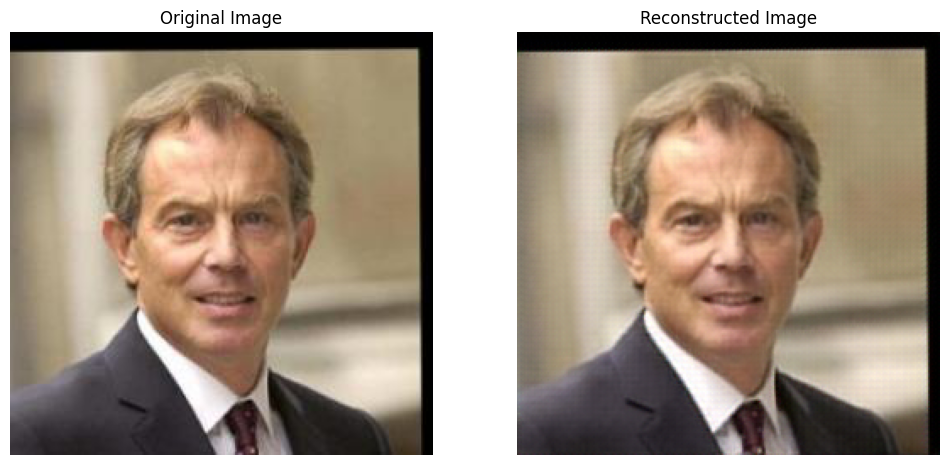

In [54]:
# Choose a random image from the dataset
sample_image, _ = random.choice(dataloader.dataset)
input_image = sample_image.unsqueeze(0)

with torch.no_grad():
    reconstructed_image = model(input_image)

# Convert the images to numpy for plotting
# Squeeze removes the batch dimension and detach takes it out of the computation graph
original_image_np = input_image.squeeze().detach().cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze().detach().cpu().numpy()

# Transpose the images from (C, H, W) to (H, W, C) for plotting
original_image_np = np.transpose(original_image_np, (1, 2, 0))
reconstructed_image_np = np.transpose(reconstructed_image_np, (1, 2, 0))

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.show()

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


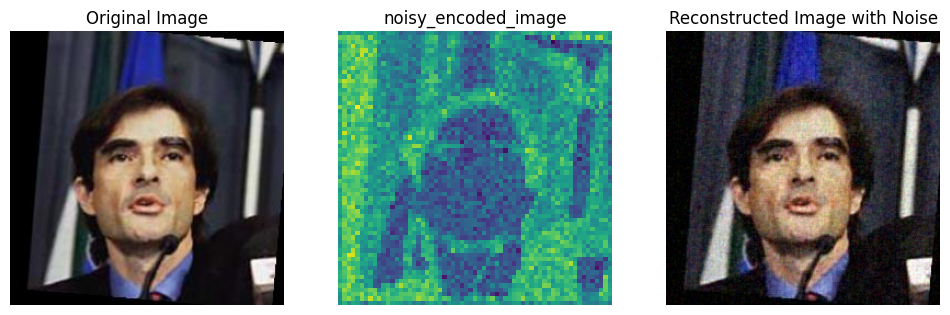

In [65]:
# Choose a random image from the dataset
sample_image, _ = random.choice(dataloader.dataset)
input_image = sample_image.unsqueeze(0)

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    encoded_image = model.encoder(input_image)

# Add small normally distributed noise to the latent representation
noise = torch.randn_like(encoded_image) * 0.20  # Adjust noise level here
noisy_encoded_image = encoded_image + noise
noisy_encoded_image_np = noisy_encoded_image.squeeze().detach().cpu().numpy()

# Decode the noisy latent image
reconstructed_image_noisy = model.decoder(noisy_encoded_image)

# Convert the images to numpy for plotting
original_image_np = input_image.squeeze().detach().cpu().numpy()
reconstructed_image_noisy_np = reconstructed_image_noisy.squeeze().detach().cpu().numpy()

# Transpose the images from (C, H, W) to (H, W, C) for plotting
original_image_np = np.transpose(original_image_np, (1, 2, 0))
reconstructed_image_noisy_np = np.transpose(reconstructed_image_noisy_np, (1, 2, 0))

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image_np)
plt.axis('off')


plt.subplot(1, 3, 2)
plt.title("noisy_encoded_image")
plt.imshow(noisy_encoded_image_np)
plt.axis('off')


plt.subplot(1, 3, 3)
plt.title("Reconstructed Image with Noise")
plt.imshow(reconstructed_image_noisy_np)
plt.axis('off')

plt.show()

## How is adding noise affecting the decoded image ?

Let's say you have a model that is being trained to identify faces. A small amount of "noise" added to the data it uses helps it stay focused on the key elements and avoid getting distracted by unimportant details or potential mistakes. It's similar to adding a little fuzziness to an image so the model can identify faces even in slightly fuzzy or imperfect images. The amount of noise we add controls this fuzziness. A model that has too much fuzziness may become confused, and a model with too little fuzziness will not be able to adapt to changes in the data. Thus, it is similar to striking the correct balance to increase the model's facial recognition accuracy.

Citation: ChatGPT